In [1]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

### 0.2 : Connection to Snowflake

In [4]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [121]:
query = run_query('''
WITH cds_time_turner_prediction AS (with base_meta_data as ( --https://github.com/HBOCodeLabs/hbomax-ci-analytics-airflow/blob/release/prod/dags/ci_analytics/resources/sql/psi/create_movie_and_season_offering_window_table.sql
            select distinct match_id, title_name, EARLIEST_OFFERED_TIMESTAMP as effective_start_date
            from max_prod.workspace.title_retail_funnel_metrics
            WHERE 1=1
            AND (( title_name  IN ('And Just Like That... S1', 'The Flight Attendant S2', 'The White Lotus S2', 'The Sex Lives of College Girls S2', 'Hacks S2', 'The Gilded Age S1', 'Euphoria S2')))
            OR  ((title_name LIKE '%And Just Like That S2%'))

        )

        , future_meta_data as(
        select distinct CASE when season_number>0 then concat(title_name, ' S', season_number) else title_name end as title_name_long
               , HOME_TERRITORY_OBSERVED_MEDAL as medal,
              season_number, PREMIERE_DATE as effective_start_date
        , case when season_number > 0 then concat(title_name, ' S', season_number) else title_name end as title_name_season
        from max_prod.content_datascience.firstview_postgl
        where ((title_name LIKE '%And Just Like That S2%'))
        OR ((title_name_long LIKE '%And Just Like That S2%'))
        )

        , launched as (
    --- % active actual
            select distinct match_id, days_on_hbo_max,'pct_active' as kpi, 'actual' as data_type, 'postlaunch' as phase, NULL as pred_day, pct_actives as value
            from max_prod.content_datascience.activepct_us_snapshot_v2

            union

    --- % view actual
            select distinct match_id, DAYS_SINCE_FIRST_OFFERED as days_on_hbo_max,'retail_view' as kpi, 'actual' as data_type, 'postlaunch' as phase, NULL as pred_day, retail_viewed_count_percent * 100 as value
            from max_prod.workspace.title_retail_funnel_metrics

            union

    --- first view actuals+postlaunch
            select distinct case when season_number > 0 then concat(title_id, '-', season_number) else title_id end as match_id, DAYS_SINCE_PREMIERE as days_on_hbo_max
            , 'first_views' as kpi
            , CASE WHEN DAYS_SINCE_PREMIERE < DATEDIFF(day, EFFECTIVE_START_DATE, GETDATE()) THEN 'actual' ELSE 'prediction' END as data_type
            , 'postlaunch' as phase, DATEDIFF(day, EFFECTIVE_START_DATE, GETDATE()) as pred_day
            , SUM(PREDICTED_FIRST_VIEWS) OVER (PARTITION BY match_id ORDER BY days_on_hbo_max) AS value
          from max_prod.content_analytics.psi_daily_rw_mean_forecast
          where schedule_label='past'

            union

    --- Pre/Post-Launch for %active
        select distinct match_id, target_day as days_on_hbo_max,'pct_active' as kpi, 'prediction' as data_type
        , case when phase = 'Post-Launch' then 'postlaunch' else 'prelaunch' end as phase
        , pred_day, prediction as value
        from max_prod.content_datascience.activepct_postlaunch_us_pred_v2
        where phase !='Post-GreenLight'
        and prediction IS NOT NULL
        qualify row_number() over(partition by match_id, target_day order by pred_day desc) = 1

            union

    --- Pre/Post-Launch for % view
        select distinct match_id, target_day as days_on_hbo_max,'retail_view' as kpi, 'prediction' as data_type
        , case when phase = 'Post-Launch' then 'postlaunch' else 'prelaunch' end as phase
        , pred_day, prediction as value
        from max_prod.content_datascience.viewpct_retail_postlaunch_us_pred
        where phase !='Post-GreenLight'
        and prediction IS NOT NULL
        qualify row_number() over(partition by match_id, target_day order by pred_day desc) = 1
        )

        , future as (
    --- pre-Launch for %active
        select distinct title_name, target_day as days_on_hbo_max,'pct_active' as kpi, 'prediction' as data_type, pred_day, prediction as value, 'postgreenlight' as phase
        from max_prod.content_datascience.activepct_postlaunch_us_pred_v2
        where phase ='Post-GreenLight'
        and prediction IS NOT NULL

            union
    --- pre-Launch for % view
        select distinct title_name, target_day as days_on_hbo_max,'retail_view' as kpi, 'prediction' as data_type, pred_day, prediction as value, 'postgreenlight' as phase
        from max_prod.content_datascience.viewpct_retail_postlaunch_us_pred
        where phase ='Post-GreenLight'
        and prediction IS NOT NULL

            union
    --- pre-Launch for first view
        select case when season_number > 0 then concat(title_name, ' S', season_number) else title_name end as title_name
        , CASE WHEN DATEDIFF(day, PREMIERE_DATE, DATEADD(month, 1, FIRST_VIEW_MONTH)) > 90 THEN 90 else DATEDIFF(day, PREMIERE_DATE, DATEADD(month, 1, FIRST_VIEW_MONTH)) end as days_on_hbo_max
        , 'first_views' as kpi, 'prediction' as data_type, DATEDIFF(day, PREMIERE_DATE, GETDATE()) AS pred_day
        , SUM(FIRST_VIEWS_PRED) OVER (PARTITION BY title_name ORDER BY days_on_hbo_max) AS value, 'postgreenlight' as phase
        from max_prod.content_datascience.firstview_postgl
        --where schedule_label='alpha'
        )

        select m.match_id, m.title_name, m.effective_start_date, days_on_hbo_max, kpi, data_type, phase, pred_day, value
        from base_meta_data m
        left join launched l on m.match_id = l.match_id

        union

        select NULL AS match_id, fm.title_name_long as title_name, fm.effective_start_date, days_on_hbo_max, kpi, data_type, phase, pred_day, value
        from future_meta_data fm
        left join future f on UPPER(fm.title_name_season) = UPPER(f.title_name)
        order by effective_start_date, match_id, DAYS_ON_HBO_MAX


          )
SELECT * FROM (
SELECT *, DENSE_RANK() OVER (ORDER BY z___min_rank) as z___pivot_row_rank, RANK() OVER (PARTITION BY z__pivot_col_rank ORDER BY z___min_rank) as z__pivot_col_ordering, CASE WHEN z___min_rank = z___rank THEN 1 ELSE 0 END AS z__is_highest_ranked_cell FROM (
SELECT *, MIN(z___rank) OVER (PARTITION BY "cds_time_turner_prediction.days_on_hbo_max") as z___min_rank FROM (
SELECT *, RANK() OVER (ORDER BY "cds_time_turner_prediction.days_on_hbo_max" ASC, z__pivot_col_rank) AS z___rank FROM (
SELECT *, DENSE_RANK() OVER (ORDER BY CASE WHEN "cds_time_turner_prediction.titles" IS NULL THEN 1 ELSE 0 END, "cds_time_turner_prediction.titles", CASE WHEN "cds_time_turner_prediction.data_type" IS NULL THEN 1 ELSE 0 END, "cds_time_turner_prediction.data_type") AS z__pivot_col_rank FROM (
SELECT
    cds_time_turner_prediction."TITLE_NAME"  AS "cds_time_turner_prediction.titles",
    cds_time_turner_prediction."DATA_TYPE"  AS "cds_time_turner_prediction.data_type",
    cds_time_turner_prediction."DAYS_ON_HBO_MAX"  AS "cds_time_turner_prediction.days_on_hbo_max",
    MAX(( cds_time_turner_prediction."VALUE"  ) ) AS "cds_time_turner_prediction.target_value"
FROM cds_time_turner_prediction
WHERE (cds_time_turner_prediction."KPI" ) = 'pct_active'
GROUP BY
    1,
    2,
    3) ww
) bb WHERE z__pivot_col_rank <= 16384
) aa
) xx
) zz
 WHERE (z__pivot_col_rank <= 50 OR z__is_highest_ranked_cell = 1) AND (z___pivot_row_rank <= 500 OR z__pivot_col_ordering = 1) ORDER BY z___pivot_row_rank

''')

In [122]:
query.head()

,cds_time_turner_prediction.titles,cds_time_turner_prediction.data_type,cds_time_turner_prediction.days_on_hbo_max,cds_time_turner_prediction.target_value,z__pivot_col_rank,z___rank,z___min_rank,z___pivot_row_rank,z__pivot_col_ordering,z__is_highest_ranked_cell
0,The White Lotus S2,actual,1,12.42,8,7,1,1,1,0
1,The Sex Lives of College Girls S2,actual,1,6.60,7,6,1,1,1,0
2,Hacks S2,actual,1,3.96,4,3,1,1,1,0
3,And Just Like That... S1,actual,1,24.19,2,1,1,1,1,1
4,The Gilded Age S1,actual,1,8.21,6,5,1,1,1,0


In [7]:
import plotly.express as px

In [123]:
query['cds_time_turner_prediction.titles'].unique()

array(['The White Lotus S2', 'The Sex Lives of College Girls S2',
       'Hacks S2', 'And Just Like That... S1', 'The Gilded Age S1',
       'The Flight Attendant S2', 'Euphoria S2', 'And Just Like That S2'],
      dtype=object)

In [124]:
query = query.rename(columns = {'cds_time_turner_prediction.days_on_hbo_max':'Days Since Launch',
                               'cds_time_turner_prediction.target_value': '% of Actives (Reach)',
                               'cds_time_turner_prediction.titles':'Title Names'},
                    )

In [125]:
query = query[query['Days Since Launch']<=28]

In [126]:
plot_df = query[query['Title Names'] != 'And Just Like That S2']

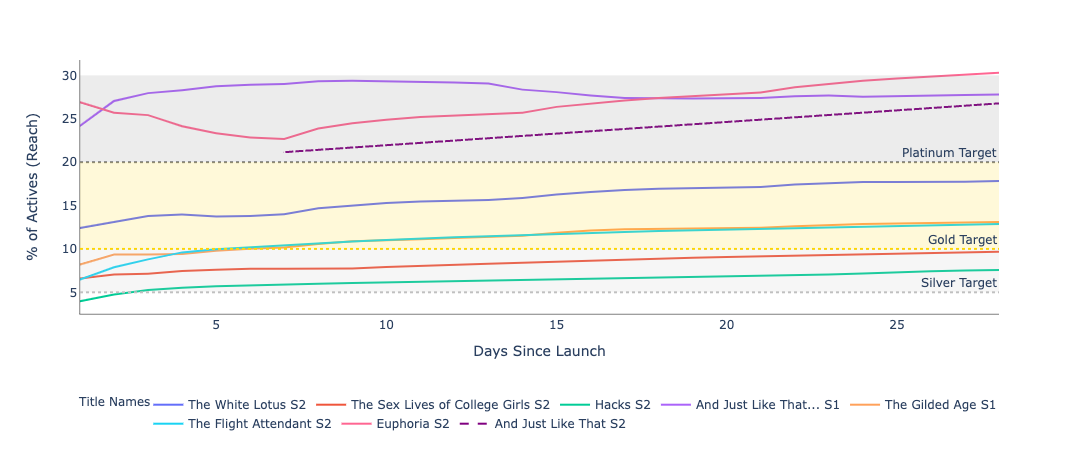

In [127]:
fig = px.line(plot_df, x="Days Since Launch", y="% of Actives (Reach)", color = 'Title Names',)
fig.add_scattergl(x = query[query['Title Names'] == 'And Just Like That S2']['Days Since Launch'], 
                  y = query[query['Title Names'] == 'And Just Like That S2']['% of Actives (Reach)'], 
                  line ={'color': 'purple', 'width' : 2, "dash": 'dash'},
#                   marker ={'opacity':0},
                   mode='lines',
                  name='And Just Like That S2', showlegend = True)


fig.add_hline(y = 5, line_width=2, line_dash="dot", line_color="silver", annotation_text = 'Silver Target')
fig.add_hline(y = 10, line_width=2, line_dash="dot", line_color="gold", annotation_text = 'Gold Target')
fig.add_hline(y = 20, line_width=2, line_dash="dot", line_color="grey", annotation_text = 'Platinum Target')

fig.add_hrect(y0=5, y1=10, fillcolor="silver", opacity=0.15, line_width=0)
fig.add_hrect(y0=10, y1=20, fillcolor="gold", opacity=0.15, line_width=0)
fig.add_hrect(y0=20, y1=30, fillcolor="grey", opacity=0.15, line_width=0)
# fig.add_hrect(y0=5, y1=5, fillcolor="silver", opacity=0.15, line_width=0)

# fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, xaxis_zeroline=True, yaxis_zeroline=True,)
fig.update_layout(plot_bgcolor='rgb(255,255,255)')
fig.update_xaxes(showline=True, linewidth=0.5, linecolor='black')
fig.update_yaxes(showline=True, linewidth=0.5, linecolor='black')

fig.update_layout(legend=dict( orientation="h",
    yanchor="top",
    y=-0.3,
    xanchor="center",
    x=0.5
))

fig.show()